In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool, cv

from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

from tqdm import tqdm

from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', None)
%matplotlib inline

In [2]:
client = pd.read_csv('data/x5-uplift-valid/data/clients2.csv')

In [3]:
products = pd.read_csv('data/x5-uplift-valid/data/products.csv')

In [4]:
train_purch = pd.read_csv('data/x5-uplift-valid/train_purch/train_purch.csv')
test_purch = pd.read_csv('data/x5-uplift-valid/test_purch/test_purch.csv')

In [5]:
train_purch.head()

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,9a80204f78,2.0,80.0,NaN
1,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,da89ebd374,1.0,65.0,NaN
2,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,0a95e1151d,1.0,24.0,NaN
3,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,4055b15e4a,2.0,50.0,NaN
4,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,a685f1916b,1.0,22.0,NaN


## EDA

### Client

In [6]:
client.head()

,client_id,client_id.1,first_issue_date,first_redeem_date,age,gender
0,000012768d,NaN,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
1,000036f903,NaN,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
2,00010925a5,NaN,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U
3,0001f552b0,NaN,2017-06-30 19:20:38,2018-08-28 12:59:45,33,F
4,00020e7b18,NaN,2017-11-27 11:41:45,2018-01-10 17:50:05,73,U


In [7]:
client.shape

(200039, 6)

In [8]:
client.describe()

,client_id.1,age
count,0.0,200039.000000
mean,NaN,46.417329
std,NaN,49.532475
min,NaN,-7491.000000
25%,NaN,34.000000
50%,NaN,45.000000
75%,NaN,59.000000
max,NaN,1852.000000


In [9]:
client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200039 entries, 0 to 200038
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   client_id          200039 non-null  object 
 1   client_id.1        0 non-null       float64
 2   first_issue_date   200039 non-null  object 
 3   first_redeem_date  182493 non-null  object 
 4   age                200039 non-null  int64  
 5   gender             200039 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.2+ MB


In [10]:
# Признак client_id.1 не содержит данных, удалим его
client.drop(columns='client_id.1', inplace=True)

In [11]:
# Посмотрим количество строк с ошибочным возрастом
client[(client['age'] > 90) | (client['age'] < 10)]['age'].shape

(749,)

In [12]:
#Заменим ошибочный возраст
client.loc[(client['age'] > 90) | (client['age'] < 10), 'age'] = 45

In [13]:
client['client_id_dec'] = client['client_id'].apply(lambda x: int(x, 16))

In [14]:
client['first_issue_date'] = client['first_issue_date'].astype("datetime64[ns]", copy=True)
client['first_redeem_date'] = client['first_redeem_date'].astype("datetime64[ns]", copy=True)

<AxesSubplot:xlabel='gender', ylabel='Count'>

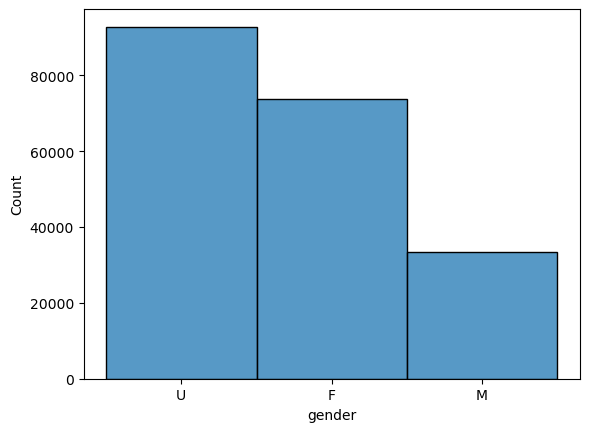

In [15]:
sns.histplot(client['gender'])

In [16]:
client['dif_date'] = (client['first_redeem_date'] - client['first_issue_date']).dt.days

In [17]:
client

,client_id,first_issue_date,first_redeem_date,age,gender,client_id_dec,dif_date
0,000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U,1209997,152.0
1,000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F,3602691,12.0
2,00010925a5,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U,17376677,51.0
3,0001f552b0,2017-06-30 19:20:38,2018-08-28 12:59:45,33,F,32854704,423.0
4,00020e7b18,2017-11-27 11:41:45,2018-01-10 17:50:05,73,U,34503448,44.0
...,...,...,...,...,...,...,...
200034,fffe0abb97,2017-11-27 08:56:54,2018-02-11 09:26:08,35,F,1099478776727,76.0
200035,fffe0ed719,2017-09-15 08:53:24,2017-12-12 14:50:12,69,U,1099479045913,88.0
200036,fffea1204c,2018-01-31 16:59:37,2018-03-12 17:02:27,73,F,1099488632908,40.0
200037,fffeca6d22,2017-12-28 11:56:13,NaT,77,F,1099491339554,NaN


### Products

In [18]:
products.head()

,product_id,level_1,level_2,level_3,level_4,segment_id,brand_id,vendor_id,netto,is_own_trademark,is_alcohol
0,0003020d3c,c3d3a8e8c6,c2a3ea8d5e,b7cda0ec0c,6376f2a852,123.0,394a54a7c1,9eaff48661,0.400,0,0
1,0003870676,e344ab2e71,52f13dac0c,d3cfe81323,6dc544533f,105.0,acd3dd483f,10486c3cf0,0.680,0,0
2,0003ceaf69,c3d3a8e8c6,f2333c90fb,419bc5b424,f6148afbc0,271.0,f597581079,764e660dda,0.500,0,0
3,000701e093,ec62ce61e3,4202626fcb,88a515c084,48cf3d488f,172.0,54a90fe769,03c2d70bad,0.112,0,0
4,0007149564,e344ab2e71,52f13dac0c,d3cfe81323,6dc544533f,105.0,63417fe1f3,f329130198,0.600,0,0


In [19]:
for i in ['segment_id', 'brand_id', 'vendor_id']:
    print(i, products[i].nunique())

segment_id 116
brand_id 4296
vendor_id 3193


In [20]:
level_1 = products['level_1'].nunique()
level_2 = products['level_2'].nunique()
level_3 = products['level_3'].nunique()
level_4 = products['level_4'].nunique()

print(f'level_1: {level_1}\nlevel_2: {level_2}\nlevel_3: {level_3}\nlevel_4: {level_4}')


level_1: 3
level_2: 42
level_3: 201
level_4: 790


In [21]:
for i in products['level_1'].unique():
    print(i, ':')
    print('level_2:', products[products['level_1'] == i]['level_2'].nunique())
    print('level_3:', products[products['level_1'] == i]['level_3'].nunique())
    print('level_4:', products[products['level_1'] == i]['level_4'].nunique())

c3d3a8e8c6 :
level_2: 12
level_3: 47
level_4: 201
e344ab2e71 :
level_2: 11
level_3: 85
level_4: 356
ec62ce61e3 :
level_2: 19
level_3: 69
level_4: 233
nan :
level_2: 0
level_3: 0
level_4: 0


Судя по всему левелы - группы товаров, например 1 уровень - продукты питания, на 2 - бакалея, овощи, фрукты и т.д

In [22]:
products[products['is_alcohol']==1]['level_4'].nunique()

38

Группа товаров алгоколя левелы 1 и 2 относится к одному левелу, что подтверждает нашу теорию.

In [23]:
products[products['is_own_trademark'] == 1]['level_2'].nunique()


22

In [24]:
for i in products['segment_id'].unique():
    print(i, ':')
    print('level_1:', products[products['segment_id'] == i]['level_2'].nunique())
    print('level_2:', products[products['segment_id'] == i]['level_2'].nunique())
    print('level_3:', products[products['segment_id'] == i]['level_3'].nunique())
    print('level_4:', products[products['segment_id'] == i]['level_4'].nunique())

123.0 :
level_1: 1
level_2: 1
level_3: 1
level_4: 5
105.0 :
level_1: 3
level_2: 3
level_3: 7
level_4: 11
271.0 :
level_1: 1
level_2: 1
level_3: 1
level_4: 10
172.0 :
level_1: 1
level_2: 1
level_3: 1
level_4: 14
165.0 :
level_1: 1
level_2: 1
level_3: 3
level_4: 7
212.0 :
level_1: 1
level_2: 1
level_3: 1
level_4: 1
48.0 :
level_1: 2
level_2: 2
level_3: 2
level_4: 8
177.0 :
level_1: 1
level_2: 1
level_3: 1
level_4: 5
116.0 :
level_1: 1
level_2: 1
level_3: 2
level_4: 9
321.0 :
level_1: 1
level_2: 1
level_3: 4
level_4: 9
150.0 :
level_1: 3
level_2: 3
level_3: 4
level_4: 7
102.0 :
level_1: 2
level_2: 2
level_3: 7
level_4: 12
85.0 :
level_1: 1
level_2: 1
level_3: 1
level_4: 4
119.0 :
level_1: 1
level_2: 1
level_3: 3
level_4: 7
111.0 :
level_1: 1
level_2: 1
level_3: 1
level_4: 13
92.0 :
level_1: 1
level_2: 1
level_3: 1
level_4: 7
214.0 :
level_1: 1
level_2: 1
level_3: 1
level_4: 2
223.0 :
level_1: 1
level_2: 1
level_3: 1
level_4: 1
148.0 :
level_1: 2
level_2: 2
level_3: 10
level_4: 35
230.0 :


Оставим значимые признаки, которые все являются категориальными и закодируем их ванхотингом

In [25]:
#list for feature encoding products
list_feat_prod = ['level_1', 'level_2', 'level_3', 'level_4', 'segment_id', 'is_own_trademark'] 

In [26]:
class client_products():
    def __init__(self, data, data_prod, list_feat_prod, n_components = 100):
        self.data = data
        self.data_prod = data_prod
        self.list_feat_prod = list_feat_prod
        self.n_components = n_components
        
    def one_hot(self):
        #Prepare products for one-hot encoding
        x = self.data_prod[self.list_feat_prod]
        x = x.to_numpy()
        x = x.reshape((-1, len(self.list_feat_prod)))
        
        #one hot encoding
        result_one = OneHotEncoder().fit_transform(x)
        return result_one.toarray()
    
    def PCA(self, x):
        pca = PCA(n_components=self.n_components)
        result_pca = pca.fit_transform(x)
        
        #transform to dataframe
        result_pca = pd.DataFrame(result_pca)
        result_pca['product_id'] = self.data_prod['product_id']
        return result_pca
        
    def prod_merge_client(self, x):
        result_prod = self.data[['client_id', 'product_id', 'product_quantity']].merge(x, how='left', on='product_id')
        
        # vectors * quantity
        s = [i for i in range(self.n_components)]
        result_prod[s] =  pd.DataFrame(np.multiply(result_prod[s].to_numpy(), result_prod['product_quantity'].to_numpy().reshape(-1, 1)))
        
        #  delete unnecessary features
        result_prod.drop(['product_id', 'product_quantity'], axis=1, inplace=True)
        
        
        return result_prod.groupby(by='client_id').sum()


In [27]:
a = client_products(train_purch, products, list_feat_prod)

In [28]:
one = a.one_hot()
one

array([[1., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.]])

In [29]:
pca = a.PCA(one)
pca

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,product_id
0,-0.759673,0.034725,0.242503,0.021811,-0.007295,0.523608,0.689012,-0.063594,-0.013803,0.000076,0.041294,-0.139563,-0.005216,-0.001777,-0.004022,0.043858,-0.075878,0.016385,0.000808,-0.031483,0.003237,0.007065,0.002376,0.009778,-0.000434,0.020441,-0.003363,-0.000238,-0.001357,-0.000764,0.000023,0.006987,0.001145,0.000999,-0.001757,0.014398,-0.012092,-0.001987,-0.023433,-0.004143,0.047505,0.310807,0.048879,-0.010029,0.242246,0.008045,-0.056673,-0.037243,0.057911,0.233539,0.693236,-0.027900,0.154393,-0.024013,0.003466,-0.007318,-0.007542,0.000404,0.000416,-0.021358,0.006360,0.040603,1.353749,0.142446,-0.001481,0.002946,-0.005084,0.046848,-0.020222,-0.045969,-0.001716,0.003779,0.005676,-0.002705,-0.012235,-0.010490,-0.005791,0.021157,-0.106276,0.200924,0.121524,0.000519,0.001741,0.002141,0.008245,-0.008274,-0.005199,-0.018534,0.004352,-0.114222,-0.017278,0.010936,0.005785,0.014103,-0.005563,-0.007633,0.038013,0.070123,-0.017548,0.161278,0003020d3c
1,1.081199,0.762228,0.169956,-0.508035,0.009162,0.003041,0.001003,-0.008582,-0.011257,0.477220,-0.025426,0.001988,0.156711,1.206612,-0.050674,0.053395,-0.025545,-0.071187,-0.008994,0.000916,-0.000551,-0.001865,0.009808,0.005949,-0.000231,0.009089,-0.001940,-0.005905,-0.084226,0.037357,0.002452,-0.048242,-0.006650,-0.000132,0.010790,0.008176,-0.001846,-0.002130,0.001441,0.000176,-0.001704,-0.005197,-0.000277,-0.000752,0.000566,0.000402,-0.003609,-0.000481,-0.000407,0.001155,0.001680,-0.000177,-0.010377,-0.001192,0.001270,-0.007591,-0.004851,0.000729,0.000426,0.003303,-0.000390,0.000609,0.003217,-0.030205,-0.000797,0.000076,0.000185,0.000385,0.002702,0.000486,-0.001182,-0.003337,0.000223,-0.000208,0.000012,0.000062,0.002335,-0.001041,0.002419,-0.001487,-0.001564,-0.000277,0.000322,0.000099,0.000189,-0.000854,-0.000721,0.000138,0.000002,-0.000209,0.002022,-0.001107,-0.000125,0.001981,-0.000232,-0.004119,0.000210,0.008339,0.001195,0.008848,0003870676
2,-0.964947,0.086053,1.243832,0.239105,-0.638624,-0.723462,-0.192879,0.015712,0.002372,-0.000507,0.003247,-0.067976,-0.012180,0.000276,0.006216,0.087052,-0.217719,0.110524,0.089088,-0.013452,-0.372989,0.250336,0.159196,-0.006841,-0.000377,0.038266,-0.005726,-0.000149,-0.012921,0.006466,-0.392831,0.002871,0.000352,-0.000065,0.000729,-0.001004,0.000625,0.000105,0.000155,-0.000075,-0.001220,-0.008063,-0.001208,0.000431,0.002294,0.000286,-0.000438,0.000739,-0.000451,-0.001392,0.001853,-0.000370,-0.005153,-0.006149,0.002530,-0.007954,-0.007835,0.000760,-0.000097,0.005800,-0.000597,0.000542,0.002215,-0.001571,0.668726,-0.011444,0.004020,-0.012233,0.085162,-0.022207,-0.013096,0.001301,-0.000275,0.000323,0.000150,-0.000148,0.000506,-0.000463,-0.001096,-0.000174,-0.000540,-0.000107,0.000432,0.032024,0.003397,-0.000099,0.000432,0.000346,-0.000590,-0.000571,-0.000484,-0.000506,-0.000792,-0.001373,0.002722,0.004186,0.004074,-0.000619,-0.007445,0.017447,0003ceaf69
3,-0.181096,-0.625480,0.277458,-0.257173,1.209219,-0.263426,-0.073677,0.036352,0.015106,0.022266,-0.022075,-0.026189,-0.081295,-0.009079,0.073479,-0.559326,-0.723079,-0.920705,-0.113243,0.012579,-0.000485,-0.001242,0.172146,-0.099260,-0.004318,-0.128634,0.018501,0.024097,0.414909,-0.237326,-0.018979,-0.387224,-0.054122,-0.001295,0.019336,-0.006248,0.185016,0.238481,0.005597,0.003908,-0.025768,-0.022059,0.253258,-0.361706,-0.001554,-0.014291,0.122911,0.018132,-0.057341,0.024706,0.016651,-0.000411,-0.049295,0.011795,-0.004049,0.006358,-0.000060,-0.000012,-0.003850,-0.022900,-0.000007,-0.000009,0.000146,-0.001705,0.000022,-0.000087,0.000226,0.000218,0.000763,0.000955,-0.000658,-0.004144,0.000708,0.003110,0.000282,-0.001303,0.001135,0.001187,-0.002146,0.000043,0.000176,0.002548,0.000031,0.004378,-0.002701

In [30]:
prod_merge_client = a.prod_merge_client(pca)
prod_merge_client

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
client_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000012768d,-9.988463,-0.319658,-17.259623,1.989308,-4.848703,-2.410757,1.012451,-5.033635,-8.178356,-1.650480,-3.228077,-0.107604,-5.427307,1.641983,0.579506,0.574316,-1.453248,1.034152,-2.332786,-2.163650,0.779054,1.358252,-0.250667,0.399750,-4.088114,-0.123691,-1.693064,2.752970,-0.485334,1.805994,0.042476,-1.166398,1.184943,2.946436,1.665490,-1.741375,0.102643,-0.070206,0.306498,-2.168735,-1.298212,1.767734,0.086625,-0.095826,-1.035928,-0.892975,-0.491181,0.604018,-0.238507,0.588794,-1.514517,-0.686446,-0.416108,-0.844621,0.438933,0.040371,4.375780,2.316554,0.136959,0.223394,-0.786969,1.503598,-0.081682,-0.378505,0.075334,-1.795992,-1.518582,-0.129443,-0.733209,-0.870729,-0.068511,-0.691604,-1.528490,-0.104838,-0.502232,-0.007559,-0.330392,-0.077462,-0.160930,-0.087851,-0.058353,4.149676,0.966512,0.019635,-0.273805,-1.792951,0.048505,-0.111987,0.863612,-0.085884,0.265347,0.256277,1.962180,0.418254,2.462286,1.480829,0.446393,0.074544,-1.098660,-0.160637
000036f903,-22.285992,20.241624,-14.487000,29.736863,-2.739127,6.232977,7.199560,-5.914535,-2.090337,0.944201,-4.833652,1.220311,-13.569374,-2.932824,5.936957,-6.315017,15.372091,-6.011771,-3.186839,-0.778574,3.861524,6.223642,4.531439,1.983734,-9.491144,4.387194,-0.723255,-0.094355,-7.313339,1.262857,2.199579,-3.664704,-4.708991,0.452318,7.178731,-2.902857,-0.902708,-0.175691,-0.147272,-1.233654,2.745409,23.442738,2.953818,-0.355425,-8.184351,-2.050480,0.052762,-2.612891,0.245884,10.354050,-1.985130,-0.327196,-0.829448,3.473789,2.347227,-8.482554,33.467234,1.999882,0.605285,0.836384,-3.401100,-3.142033,-1.271103,0.143502,-1.785603,-5.195787,0.995922,-1.146870,16.441018,13.911457,3.117897,14.418480,-3.552135,1.936887,-5.669458,1.077187,-0.595579,-1.577352,3.708229,-8.378079,-4.700891,4.544965,0.611756,-0.094569,1.973153,8.811826,0.254277,-1.570126,0.871617,-1.795015,-0.291394,-0.755437,-2.713960,-0.218485,-1.256062,-0.772625,-0.391968,1.151667,5.342244,2.339217
0001f552b0,23.596421,-27.536659,-10.964846,-1.703126,-15.832587,4.563244,-0.184472,-7.726079,-11.543811,-2.026518,1.551334,4.460047,-1.867720,2.704403,5.078952,-0.951105,2.419670,-0.066417,2.696921,1.167832,2.027019,2.483753,-1.411104,-0.712462,0.366659,0.760622,0.804929,-1.834636,5.485947,-2.083629,-0.171660,6.911803,0.923293,0.059775,8.101905,5.411991,-10.484718,7.016887,1.356933,-4.954868,3.357051,4.798108,0.696689,3.597646,0.466178,-4.421468,33.264925,9.532850,48.579526,1.200203,-1.008596,0.086527,-5.183386,-8.246979,1.238439,0.076115,8.815912,-0.187374,1.844798,-0.260820,1.892822,-0.919268,0.417945,-0.825512,-0.306067,-1.352998,-0.202841,-0.460935,0.799456,-1.802394,-2.690854,-1.990738,-1.949775,2.666808,-0.332366,0.235472,-3.853308,2.468651,1.822931,0.685610,0.905200,0.112499,-0.264439,-0.265647,0.973592,-0.008668,0.007773,-0.100668,2.011431,-0.503235,1.561712,-1.825641,3.702225,-0.351847,-4.161770,-2.179986,-0.794041,-0.689983,0.251092,-0.430566
00020e7b18,-104.153751,33.366153,-79.329473,-9.613373,-46.714891,-33.796296,-8.713225,-3.328249,-19.767105,22.461969,-4.628765,26.428852,-17.989080,6.255679,57.575869,3.138558,-3.843465,10.859548,-17.587040,0.706053,-4.128457,17.817505,3.793654,25.881826,-39.440387,0.168983,-0.844150,7.416767,5.145867,-1.143403,-5.734439,1.461933,5.536596,54.880430,-10.172369,0.828252,1.862914,-2.083258,-3.359214,-4.150898,-0.258622,14.607095,1.483277,1.854004,-6.566622,0.920023,5.786025,-3.018226,-6.728360,9.042426,-3.041284,8.550070,-6.926877,-5.438061,6.853283,-6.411722,29.541341,6.906326,0.879431,0.696609,-4.274893,3.851712,-2.872389,-6.144426,9.501611,2.588590,-3.466561,-2.383083,-1.470011

In [31]:
train_purch.head()

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,9a80204f78,2.0,80.0,NaN
1,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,da89ebd374,1.0,65.0,NaN
2,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,0a95e1151d,1.0,24.0,NaN
3,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,4055b15e4a,2.0,50.0,NaN
4,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,a685f1916b,1.0,22.0,NaN


In [37]:
train_purch['price'] = train_purch['trn_sum_from_iss'] / train_purch['product_quantity']

In [38]:
train_purch

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red,price
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,9a80204f78,2.0,80.0,NaN,40.0
1,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,da89ebd374,1.0,65.0,NaN,65.0
2,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,0a95e1151d,1.0,24.0,NaN,24.0
3,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,4055b15e4a,2.0,50.0,NaN,25.0
4,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,a685f1916b,1.0,22.0,NaN,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15998947,fffeca6d22,a0bb11a968,2019-03-09 07:47:43,0.4,0.0,0.0,0.0,99.0,a0613e36b5,de437430e2,1.0,19.0,NaN,19.0
15998948,fffeca6d22,a0bb11a968,2019-03-09 07:47:43,0.4,0.0,0.0,0.0,99.0,a0613e36b5,ad8fee4200,1.0,45.0,NaN,45.0
15998949,fffeca6d22,3b876a5532,2019-03-15 14:46:39,0.8,0.0,0.0,0.0,165.0,a0613e36b5,ad8fee4200,2.0,94.0,NaN,47.0
15998950,fffeca6d22,3b876a5532,2019-03-15 14:46:39,0.8,0.0,0.0,0.0,165.0,a0613e36b5,230dbb0c16,1.0,50.0,NaN,50.0


In [36]:
train_purch.groupby(by='client_id').sum()

,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,product_quantity,trn_sum_from_iss,trn_sum_from_red
client_id,,,,,,,,
000012768d,392.7,0.0,0.0,0.0,40809.00,54.0,2805.0,0.0
000036f903,348.3,360.0,0.0,0.0,58765.00,169.0,9810.0,0.0
0001f552b0,552.2,0.0,0.0,0.0,47974.34,106.0,6155.0,0.0
00020e7b18,6088.0,0.0,-2674.0,-330.0,558970.46,394.0,25206.0,5885.0
000220a0a7,896.6,0.0,0.0,0.0,69487.58,140.0,8612.0,0.0
...,...,...,...,...,...,...,...,...
fffd5cd0c6,273.8,0.0,0.0,0.0,41427.23,119.0,5739.0,0.0
fffd63dfe3,43.7,0.0,0.0,0.0,9018.59,31.0,1343.0,0.0
fffd8c9d7d,61.0,0.0,0.0,0.0,8154.43,27.0,1637.0,0.0
